# Email Analysis and Classification for SPAM Detection

Objectives:
1. Train a classifier to identify SPAM emails.
2. Identify the main Topics among the emails classified as SPAM.
3. Calculate the semantic distance between the obtained topics to evaluate the heterogeneity of the SPAM emails contents.
4. Extract from the NON-SPAM emails the information about the mentioned Organizations.

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Core Libraries
import pandas as pd
import numpy as np
from collections import Counter
import re

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')

# Machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Gensim and Topic Modeling Libraries
from gensim import corpora
import gensim
from gensim.models import CoherenceModel
from gensim.matutils import sparse2full

# Distance Metrics
from scipy.spatial.distance import jensenshannon

# PyLDAVis for Topic Visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Handling Imbalanced Data
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler


# SpaCy for Named Entity Recognition
import spacy

C:\Users\dniko\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dniko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dniko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Train a classifier to identify SPAM emails

### Loading Dataset and Exploratory Data Analysis

In [2]:
df_bck = pd.read_csv("spam_dataset.csv")

In [3]:
print(df_bck)

      Unnamed: 0 label                                               text  \
0            605   ham  Subject: enron methanol ; meter # : 988291\nth...   
1           2349   ham  Subject: hpl nom for january 9 , 2001\n( see a...   
2           3624   ham  Subject: neon retreat\nho ho ho , we ' re arou...   
3           4685  spam  Subject: photoshop , windows , office . cheap ...   
4           2030   ham  Subject: re : indian springs\nthis deal is to ...   
...          ...   ...                                                ...   
5166        1518   ham  Subject: put the 10 on the ft\nthe transport v...   
5167         404   ham  Subject: 3 / 4 / 2000 and following noms\nhpl ...   
5168        2933   ham  Subject: calpine daily gas nomination\n>\n>\nj...   
5169        1409   ham  Subject: industrial worksheets for august 2000...   
5170        4807  spam  Subject: important online banking alert\ndear ...   

      label_num  
0             0  
1             0  
2             0  
3  

In [4]:
df = df_bck.copy()

In [5]:
print("Dataset Information:")
df.info()
print(df.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB
   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\nth...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\n( see a...   
2        3624   ham  Subject: neon retreat\nho ho ho , we ' re arou...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\nthis deal is to ...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  


In [6]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64



Distribution of SPAM vs Not SPAM:
label
ham     3672
spam    1499
Name: count, dtype: int64


C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


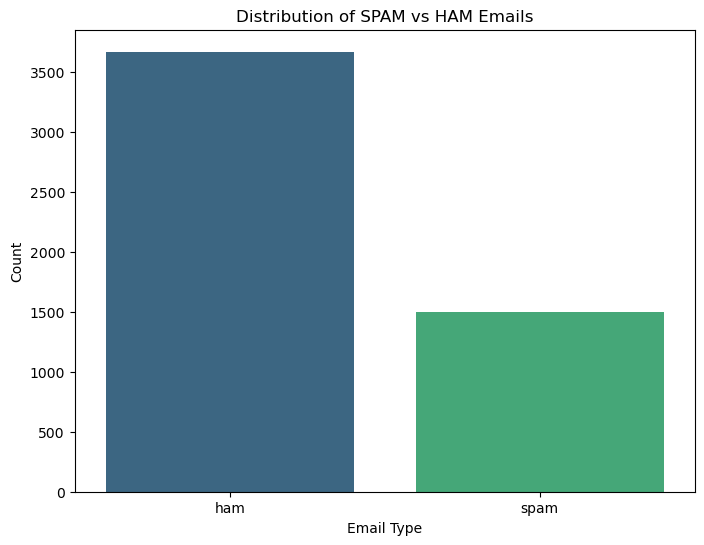

In [7]:
# Display the distribution of the target variable (SPAM/Not SPAM)
print("\nDistribution of SPAM vs Not SPAM:")
print(df['label'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label', palette='viridis')
plt.title('Distribution of SPAM vs HAM Emails')
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.show()

In [8]:
# Check for duplicate rows
print("\nNumber of duplicate rows:")
print(df.duplicated().sum())


Number of duplicate rows:
0


In [9]:
# Check if all mail start with "Subject"
all_start_with_subject = df['text'].str.startswith('Subject').all()
print("\nAll emails start with 'Subject':", all_start_with_subject)


All emails start with 'Subject': True


In [10]:
# Drop the 'Unnamed: 0' column
df = df.drop(columns=['Unnamed: 0'])

# Remove the word "Subject:" from the beginning of each email
df['text'] = df['text'].str.replace(r'^Subject: ', '', regex=True)

In [11]:
df.head()

,label,text,label_num
0,ham,enron methanol ; meter # : 988291\nthis is a f...,0
1,ham,"hpl nom for january 9 , 2001\n( see attached f...",0
2,ham,"neon retreat\nho ho ho , we ' re around to tha...",0
3,spam,"photoshop , windows , office . cheap . main tr...",1
4,ham,re : indian springs\nthis deal is to book the ...,0


* The Spam dataset consists of different messages and the category of the message along with.
* There are 5171 rows and 4 columns provided in the data.
* The distribution of SPAM vs Not SPAM is unbalanced with 3672 ham emails and 1499 spam
* There aren't duplicate rows present in the dataset.
* No Null values exist, 
* Drop the 'Unnamed: 0' column

### Preprocessing the Text in the Dataset

In [12]:
# Splitting the data to train and te
X = df['text']
y = df['label_num']

#### Creating a function to lowercase the text, remove special characters, normalize certain words, use stems of words instead of the original form using porter stemmer algorithm. creating tokenizer function to i ) Create a space between special characters and ii) Split based on whitespace. 

In [13]:
porter_stemmer=PorterStemmer()
def preprocessor(text):
    
    text=text.lower() 
    text=re.sub("\\W"," ",text) 
    text=re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ",text) 
    words=re.split("\\s+",text)
    stemmed_words=[porter_stemmer.stem(word=word) for word in words]
    return ' '.join(stemmed_words)

def tokenizer(text):
    text=re.sub("(\\W)"," \\1 ",text)
    return re.split("\\s+",text)

#### Count Vectorizer is used to transform a corpus of text to a vector of term.
min_df = 0.06 ( taking 0.6% of Minimum Document Frequency )
ngram_range=(1,2) ( word level Unigrams and bigrams)

Adapted by https://medium.com/@dssc2022yt/spam-ham-email-detection-d548a6d5869e

In [14]:
vectorizer = CountVectorizer(tokenizer=tokenizer,ngram_range=(1,2),min_df=0.006,preprocessor=preprocessor)
X  = vectorizer.fit_transform(X)

C:\Users\dniko\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### Handling unbalanced data
As previous seen target class has an uneven distribution of observations. 
Application of random over sampling method to balance the target variable’s observation.

In [15]:
ros = RandomOverSampler(random_state=42)

print('Original dataset shape', Counter(y))

# fit predictor and target 
X,y = ros.fit_resample(X, y)

print('Modified dataset shape', Counter(y))

Original dataset shape Counter({0: 3672, 1: 1499})
Modified dataset shape Counter({0: 3672, 1: 3672})


## ML Model Implementation

#### Data Splitting

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20, random_state=42)

#### Function to train and evaluate the model

In [17]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    '''The function will take model, x train, x test, y train, y test
    and then it will fit the model, then make predictions on the trained model,
    it will then print roc-auc score of train and test, then plot the roc, auc curve,
    print confusion matrix for train and test, then print classification report for train and test,
    then plot the feature importances if the model has feature importances,
    and finally it will return the following scores as a list:
    recall_train, recall_test, acc_train, acc_test, roc_auc_train, roc_auc_test, F1_train, F1_test
    '''

    # fit the model on the training data
    model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    pred_prob_train = model.predict_proba(X_train)[:,1]
    pred_prob_test = model.predict_proba(X_test)[:,1]

    # calculate ROC AUC score
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    roc_auc_test = roc_auc_score(y_test, y_pred_test)
    print("\nTrain ROC AUC:", roc_auc_train)
    print("Test ROC AUC:", roc_auc_test)

    # plot the ROC curve
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_prob_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_prob_test)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr_train, tpr_train, label="Train ROC AUC: {:.2f}".format(roc_auc_train))
    plt.plot(fpr_test, tpr_test, label="Test ROC AUC: {:.2f}".format(roc_auc_test))
    plt.legend()
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # calculate confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    fig, ax = plt.subplots(1, 2, figsize=(11,4))

    print("\nConfusion Matrix:")
    sns.heatmap(cm_train, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[0])
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    ax[0].set_title("Train Confusion Matrix")

    sns.heatmap(cm_test, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[1])
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")
    ax[1].set_title("Test Confusion Matrix")

    plt.tight_layout()
    plt.show()


    # calculate classification report
    cr_train = classification_report(y_train, y_pred_train, output_dict=True)
    cr_test = classification_report(y_test, y_pred_test, output_dict=True)
    print("\nTrain Classification Report:")
    crt = pd.DataFrame(cr_train).T
    print(crt.to_markdown())
    # sns.heatmap(pd.DataFrame(cr_train).T.iloc[:, :-1], annot=True, cmap="Blues")
    print("\nTest Classification Report:")
    crt2 = pd.DataFrame(cr_test).T
    print(crt2.to_markdown())
    # sns.heatmap(pd.DataFrame(cr_test).T.iloc[:, :-1], annot=True, cmap="Blues")


    precision_train = cr_train['weighted avg']['precision']
    precision_test = cr_test['weighted avg']['precision']

    recall_train = cr_train['weighted avg']['recall']
    recall_test = cr_test['weighted avg']['recall']

    acc_train = accuracy_score(y_true = y_train, y_pred = y_pred_train)
    acc_test = accuracy_score(y_true = y_test, y_pred = y_pred_test)

    F1_train = cr_train['weighted avg']['f1-score']
    F1_test = cr_test['weighted avg']['f1-score']

    model_score = [precision_train, precision_test, recall_train, recall_test, acc_train, acc_test, roc_auc_train, roc_auc_test, F1_train, F1_test ]
    return model_score

### Multinomial Naive Bayes


Train ROC AUC: 0.9639128656906572
Test ROC AUC: 0.9578355325725155


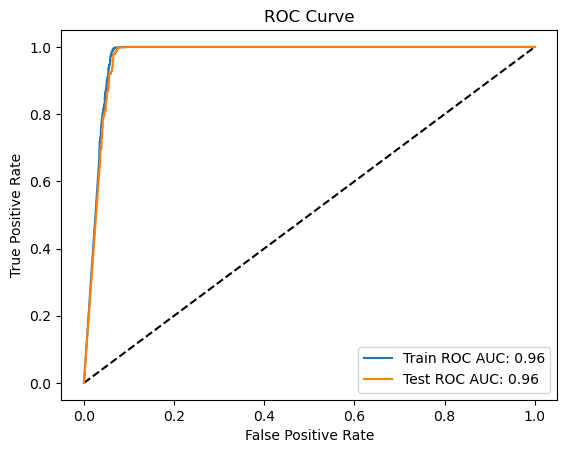


Confusion Matrix:


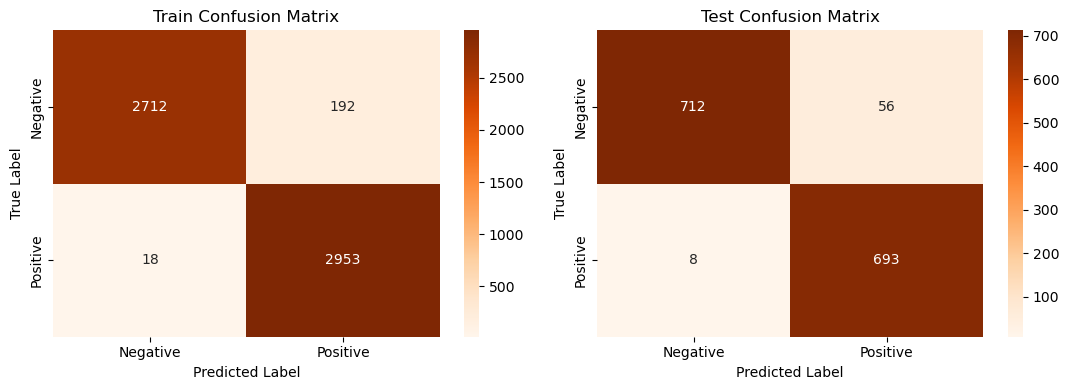


Train Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.993407 | 0.933884 |   0.962726 | 2904        |
| 1            |    0.938951 | 0.993941 |   0.965664 | 2971        |
| accuracy     |    0.964255 | 0.964255 |   0.964255 |    0.964255 |
| macro avg    |    0.966179 | 0.963913 |   0.964195 | 5875        |
| weighted avg |    0.965868 | 0.964255 |   0.964212 | 5875        |

Test Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.988889 | 0.927083 |   0.956989 |  768        |
| 1            |    0.925234 | 0.988588 |   0.955862 |  701        |
| accuracy     |    0.956433 | 0.956433 |   0.956433 |    0.956433 |
| macro avg    |    0.957061 | 0.957836 |   0.956426 | 1469        |
| weighted avg |    0.958513 | 0.956433 |   

In [19]:
nb =  MultinomialNB()
# Visualizing evaluation Metric Score chart
nb_score = train_and_evaluate_model(nb, X_train, X_test, y_train, y_test)

### Decision Tree

In [20]:
dt = DecisionTreeClassifier()


Train ROC AUC: 1.0
Test ROC AUC: 0.972158449239182


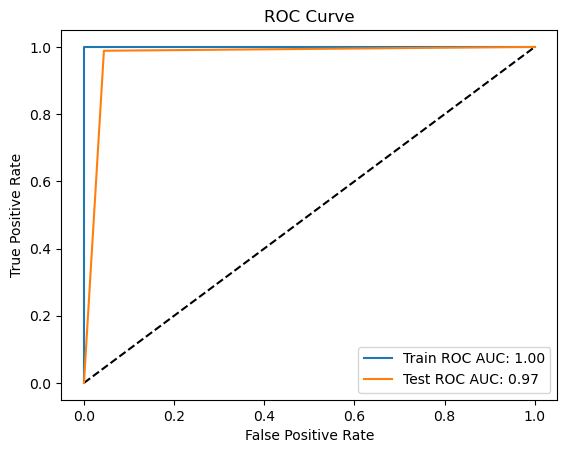


Confusion Matrix:


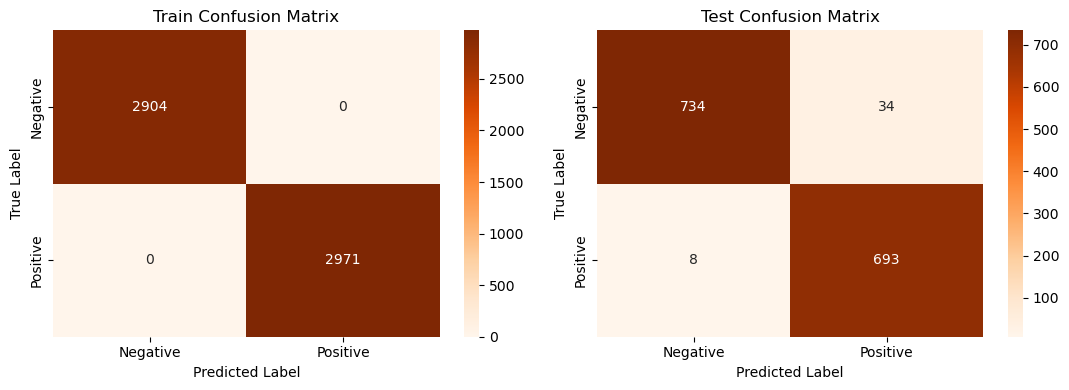


Train Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |           1 |        1 |          1 |      2904 |
| 1            |           1 |        1 |          1 |      2971 |
| accuracy     |           1 |        1 |          1 |         1 |
| macro avg    |           1 |        1 |          1 |      5875 |
| weighted avg |           1 |        1 |          1 |      5875 |

Test Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.989218 | 0.955729 |   0.972185 |  768        |
| 1            |    0.953232 | 0.988588 |   0.970588 |  701        |
| accuracy     |    0.971409 | 0.971409 |   0.971409 |    0.971409 |
| macro avg    |    0.971225 | 0.972158 |   0.971387 | 1469        |
| weighted avg |    0.972046 | 0.971409 |   0.971423 | 146

In [21]:
# Visualizing evaluation Metric Score chart
dt_score = train_and_evaluate_model(dt, X_train, X_test, y_train, y_test)

### Random Forest

In [22]:
rf = RandomForestClassifier()


Train ROC AUC: 1.0
Test ROC AUC: 0.984375


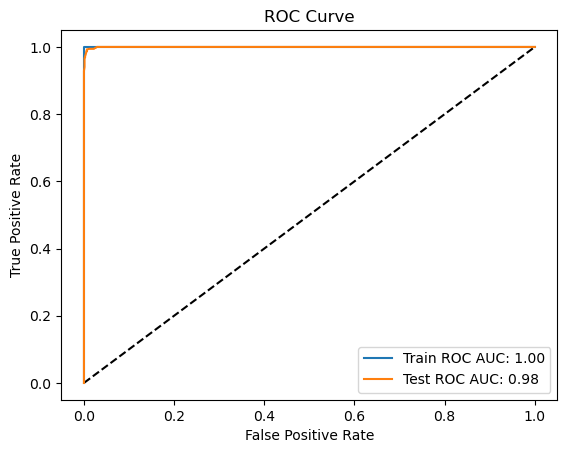


Confusion Matrix:


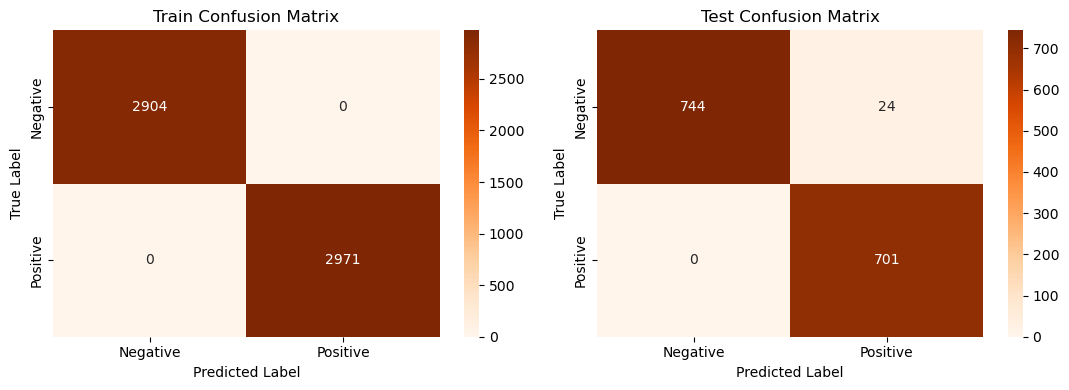


Train Classification Report:
|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |           1 |        1 |          1 |      2904 |
| 1            |           1 |        1 |          1 |      2971 |
| accuracy     |           1 |        1 |          1 |         1 |
| macro avg    |           1 |        1 |          1 |      5875 |
| weighted avg |           1 |        1 |          1 |      5875 |

Test Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    1        | 0.96875  |   0.984127 |  768        |
| 1            |    0.966897 | 1        |   0.98317  |  701        |
| accuracy     |    0.983662 | 0.983662 |   0.983662 |    0.983662 |
| macro avg    |    0.983448 | 0.984375 |   0.983648 | 1469        |
| weighted avg |    0.984203 | 0.983662 |   0.98367  | 146

In [23]:
# Visualizing evaluation Metric Score chart
rf_score = train_and_evaluate_model(rf, X_train, X_test, y_train, y_test)

### Support Vector Machine

In [24]:
svc = SVC(probability=True)


Train ROC AUC: 0.9635063881988701
Test ROC AUC: 0.9522872830480266


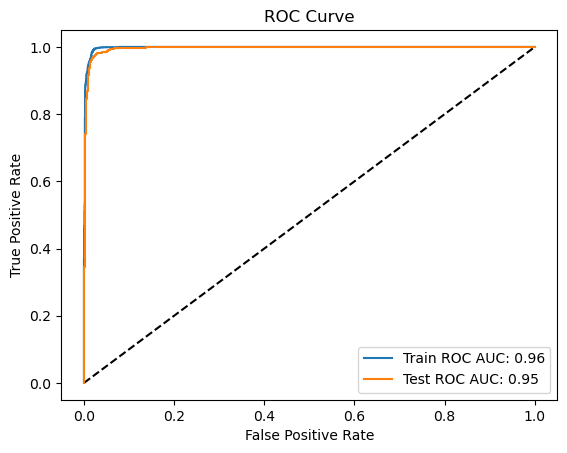


Confusion Matrix:


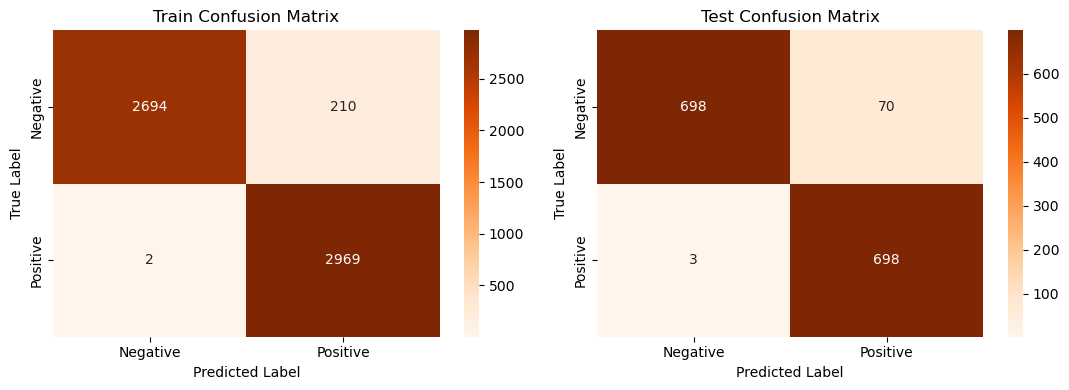


Train Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.999258 | 0.927686 |   0.962143 | 2904        |
| 1            |    0.933941 | 0.999327 |   0.965528 | 2971        |
| accuracy     |    0.963915 | 0.963915 |   0.963915 |    0.963915 |
| macro avg    |    0.9666   | 0.963506 |   0.963836 | 5875        |
| weighted avg |    0.966227 | 0.963915 |   0.963855 | 5875        |

Test Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.99572  | 0.908854 |   0.950306 |  768        |
| 1            |    0.908854 | 0.99572  |   0.950306 |  701        |
| accuracy     |    0.950306 | 0.950306 |   0.950306 |    0.950306 |
| macro avg    |    0.952287 | 0.952287 |   0.950306 | 1469        |
| weighted avg |    0.954268 | 0.950306 |   

In [25]:
# Visualizing evaluation Metric Score chart
svc_score = train_and_evaluate_model(svc, X_train, X_test, y_train, y_test)

### All models Results

In [26]:
# Creation of the dictionary containing the different metrics
models_metrics = {
    'Multinomial Naive Bayes': {
        'Precision (Train)': nb_score[0],
        'Precision (Test)': nb_score[1],
        'Recall (Train)': nb_score[2],
        'Recall (Test)': nb_score[3],
        'Accuracy (Train)': nb_score[4],
        'Accuracy (Test)': nb_score[5],
        'ROC AUC (Train)': nb_score[6],
        'ROC AUC (Test)': nb_score[7],
        'F1-Score (Train)': nb_score[8],
        'F1-Score (Test)': nb_score[9]
    },
    'Decision Tree': {
        'Precision (Train)': dt_score[0],
        'Precision (Test)': dt_score[1],
        'Recall (Train)': dt_score[2],
        'Recall (Test)': dt_score[3],
        'Accuracy (Train)': dt_score[4],
        'Accuracy (Test)': dt_score[5],
        'ROC AUC (Train)': dt_score[6],
        'ROC AUC (Test)': dt_score[7],
        'F1-Score (Train)': dt_score[8],
        'F1-Score (Test)': dt_score[9]
    },
    'Random Forest': {
        'Precision (Train)': rf_score[0],
        'Precision (Test)': rf_score[1],
        'Recall (Train)': rf_score[2],
        'Recall (Test)': rf_score[3],
        'Accuracy (Train)': rf_score[4],
        'Accuracy (Test)': rf_score[5],
        'ROC AUC (Train)': rf_score[6],
        'ROC AUC (Test)': rf_score[7],
        'F1-Score (Train)': rf_score[8],
        'F1-Score (Test)': rf_score[9]
    },
    'Support Vector Classifier': {
        'Precision (Train)': svc_score[0],
        'Precision (Test)': svc_score[1],
        'Recall (Train)': svc_score[2],
        'Recall (Test)': svc_score[3],
        'Accuracy (Train)': svc_score[4],
        'Accuracy (Test)': svc_score[5],
        'ROC AUC (Train)': svc_score[6],
        'ROC AUC (Test)': svc_score[7],
        'F1-Score (Train)': svc_score[8],
        'F1-Score (Test)': svc_score[9]
    }
}

# Conversion in DataFrame in order to better visualization
models_metrics_df = pd.DataFrame(models_metrics).T
print(models_metrics_df)

                           Precision (Train)  Precision (Test)  \
Multinomial Naive Bayes             0.965868          0.958513   
Decision Tree                       1.000000          0.972046   
Random Forest                       1.000000          0.984203   
Support Vector Classifier           0.966227          0.954268   

                           Recall (Train)  Recall (Test)  Accuracy (Train)  \
Multinomial Naive Bayes          0.964255       0.956433          0.964255   
Decision Tree                    1.000000       0.971409          1.000000   
Random Forest                    1.000000       0.983662          1.000000   
Support Vector Classifier        0.963915       0.950306          0.963915   

                           Accuracy (Test)  ROC AUC (Train)  ROC AUC (Test)  \
Multinomial Naive Bayes           0.956433         0.963913        0.957836   
Decision Tree                     0.971409         1.000000        0.972158   
Random Forest                     0.98366

**Comparative Model Performance Analysis:**

__Random Forest - Best Performer__: Highest overall performance across metrics
1. Test Accuracy: 98.37%
2. Test F1-Score: 0.9837
3. Test ROC AUC: 0.9844
4. Perfect training performance (1.0 across all metrics)

Pros:
- Most stable and generalized model
- Excellent precision and recall
- Minimal performance drop between training and test sets


__Decision Tree__: Strong second-best model
1. Test Accuracy: 97.14%
2. Test F1-Score: 0.9714
3. Test ROC AUC: 0.9723
4. Perfect training performance (1.0 across all metrics)

Pros:
- Very good predictive power
- High generalization capability

Potential Concern: Slight overfitting risk due to perfect training performance


__Multinomial Naive Bayes__: Solid performance with more conservative results
1. Test Accuracy: 95.64%
2. Test F1-Score: 0.9565
3. Test ROC AUC: 0.9578

Pros:
- Most stable performance across train and test sets
- No significant overfitting
- Slightly lower performance compared to ensemble methods


__Support Vector Classifier (SVC)__: Lowest performance among the models
1. Test Accuracy: 95.03%
2. Test F1-Score: 0.9503
3. Test ROC AUC: 0.9523

Pros:
- Consistent performance
- Reliable classification

Cons:
- Lowest accuracy and F1-score
- Most significant performance drop from training to test set

# Identification of main Topics among the SPAM mails in the dataset and calculation of the semantic distance between the obtained topics to evaluate the heterogeneity of the SPAM emails contents.

Adapted by material course of ProfessionAI and https://github.com/aspagnuolo/Spam_Mail_Analysis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dniko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dniko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


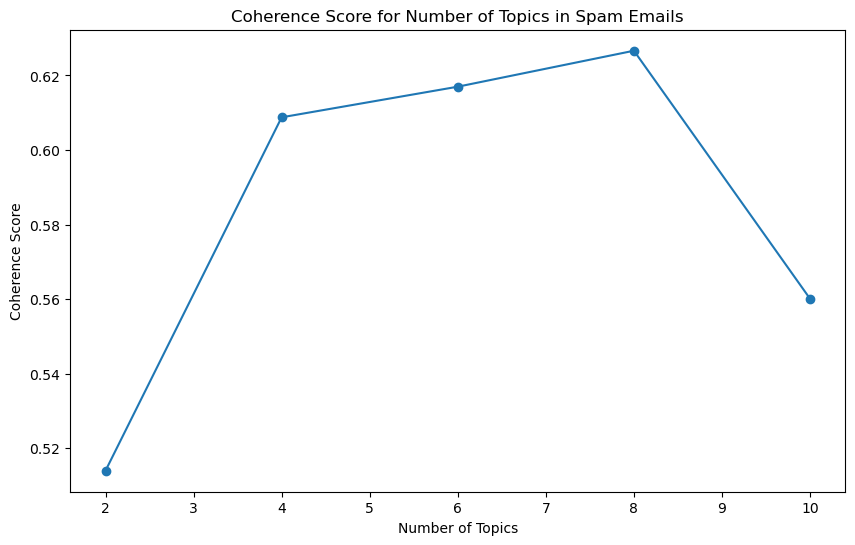

Optimal number of topics: 8

Topics and their top words:
Topic 1: 0.010*"company" + 0.006*"com" + 0.005*"statement" + 0.005*"http" + 0.004*"may"
Topic 2: 0.015*"pill" + 0.004*"viagra" + 0.004*"get" + 0.003*"http" + 0.003*"prescription"
Topic 3: 0.007*"company" + 0.006*"gas" + 0.005*"price" + 0.004*"oil" + 0.004*"stock"
Topic 4: 0.009*"company" + 0.006*"statement" + 0.006*"stock" + 0.005*"information" + 0.004*"security"
Topic 5: 0.010*"com" + 0.006*"computron" + 0.006*"www" + 0.005*"please" + 0.005*"contact"
Topic 6: 0.004*"get" + 0.003*"time" + 0.003*"said" + 0.003*"http" + 0.003*"money"
Topic 7: 0.017*"nbsp" + 0.016*"font" + 0.016*"http" + 0.011*"width" + 0.011*"height"
Topic 8: 0.011*"price" + 0.007*"window" + 0.007*"adobe" + 0.007*"http" + 0.006*"microsoft"


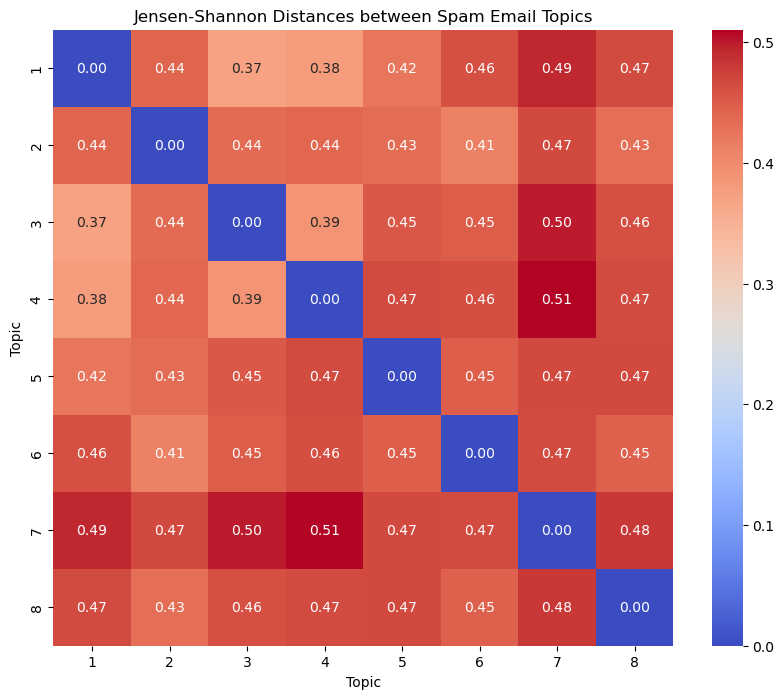

In [28]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_spam_text(text):
    """
    Preprocess spam email text by converting to lowercase, removing punctuation and numbers,
    tokenizing, removing stopwords, and lemmatizing.
    
    Parameters:
    text (str): The input text.
    
    Returns:
    list: The preprocessed tokens.
    """
    # Remove the word "Subject:" from the beginning of each email
    text = re.sub(r'^Subject: ', '', text, flags=re.IGNORECASE)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    stopwords_set = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_set and len(token) > 2]
    return tokens

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute coherence values for different numbers of topics.
    
    Parameters:
    dictionary (gensim.corpora.Dictionary): The dictionary created from the texts.
    corpus (list of list of (int, int)): The corpus created from the texts.
    texts (list of list of str): The preprocessed texts.
    limit (int): The maximum number of topics.
    start (int): The minimum number of topics.
    step (int): The step size for the number of topics.
    
    Returns:
    list: List of LDA models.
    list: Coherence values for each number of topics.
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def find_optimal_number_of_topics(coherence_values, start=2, step=3):
    """
    Find the optimal number of topics based on coherence values.
    
    Parameters:
    coherence_values (list): List of coherence values.
    start (int): The starting number of topics.
    step (int): The step size for the number of topics.
    
    Returns:
    int: The optimal number of topics.
    """
    x = range(start, start + step * len(coherence_values), step)
    optimal_num_topics = x[coherence_values.index(max(coherence_values))]
    return optimal_num_topics

def plot_coherence_values(coherence_values, start=2, step=3, limit=12):
    """
    Plot coherence values for different numbers of topics.
    
    Parameters:
    coherence_values (list): List of coherence values.
    start (int): The starting number of topics.
    step (int): The step size for the number of topics.
    limit (int): The maximum number of topics.
    """
    plt.figure(figsize=(10, 6))
    x = range(start, limit, step)
    plt.plot(x, coherence_values, marker='o')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Score for Number of Topics in Spam Emails")
    plt.show()

def get_topic_distributions(lda_model, num_topics, dictionary):
    """
    Extract topic distributions from the LDA model.
    
    Parameters:
    lda_model (gensim.models.ldamodel.LdaModel): The trained LDA model.
    num_topics (int): The number of topics.
    dictionary (gensim.corpora.Dictionary): The dictionary created from the texts.
    
    Returns:
    list: List of topic distributions.
    """
    topic_distributions = []
    for i in range(num_topics):
        topic_words = lda_model.get_topic_terms(i, topn=len(dictionary))
        topic_distributions.append(sparse2full(topic_words, len(dictionary)))
    return topic_distributions

def calculate_js_distances(topic_distributions, num_topics):
    """
    Calculate Jensen-Shannon distances between topic distributions.
    
    Parameters:
    topic_distributions (list): List of topic distributions.
    num_topics (int): The number of topics.
    
    Returns:
    np.array: Matrix of Jensen-Shannon distances.
    """
    js_distances = np.zeros((num_topics, num_topics))
    for i in range(num_topics):
        for j in range(num_topics):
            if i != j:
                js_distances[i][j] = jensenshannon(topic_distributions[i], topic_distributions[j])
            else:
                js_distances[i][j] = 0.0
    return js_distances

def plot_js_distances(js_distances, num_topics):
    """
    Plot a heatmap of Jensen-Shannon distances between topics.
    
    Parameters:
    js_distances (np.array): Matrix of Jensen-Shannon distances.
    num_topics (int): The number of topics.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(js_distances, annot=True, fmt=".2f", cmap='coolwarm', 
                xticklabels=range(1, num_topics + 1), 
                yticklabels=range(1, num_topics + 1))
    plt.title('Jensen-Shannon Distances between Spam Email Topics')
    plt.xlabel('Topic')
    plt.ylabel('Topic')
    plt.savefig('ensen-Shannon Distances.png')
    plt.show()

def analyze_spam_topics(df):
    """
    Comprehensive function to analyze topics in spam emails.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing email data.
    
    Returns:
    dict: Dictionary containing LDA model, topics, and topic analysis results.
    """
    # Preprocess the text and filter for SPAM emails
    df['preprocessed_spam_text'] = df['text'].apply(preprocess_spam_text)
    df_spam = df[df['label'] == 'spam']
    
    # Create a dictionary and corpus for LDA
    dictionary = corpora.Dictionary(df_spam['preprocessed_spam_text'])
    corpus = [dictionary.doc2bow(text) for text in df_spam['preprocessed_spam_text']]
    
    # Compute coherence values for different numbers of topics
    model_list, coherence_values = compute_coherence_values(
        dictionary=dictionary, 
        corpus=corpus, 
        texts=df_spam['preprocessed_spam_text'], 
        start=2, 
        limit=12, 
        step=2
    )
    
    # Plot coherence values
    plot_coherence_values(coherence_values, start=2, step=2, limit=12)
    
    # Determine the optimal number of topics
    optimal_num_topics = find_optimal_number_of_topics(coherence_values, start=2, step=2)
    print(f"Optimal number of topics: {optimal_num_topics}")
    
    # Build LDA model with optimal number of topics
    lda_model = gensim.models.LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=optimal_num_topics,
        passes=3
    )
    
    # Print topics and their top words
    print("\nTopics and their top words:")
    topics = lda_model.print_topics(num_words=5)
    for i, topic in enumerate(topics, start=1):
        print(f"Topic {i}: {topic[1]}")
    
    # Extract topic distributions and calculate Jensen-Shannon distances
    topic_distributions = get_topic_distributions(lda_model, optimal_num_topics, dictionary)
    js_distances = calculate_js_distances(topic_distributions, optimal_num_topics)
    
    # Plot Jensen-Shannon distance heatmap
    plot_js_distances(js_distances, optimal_num_topics)
    
    return {
        'lda_model': lda_model,
        'optimal_topics': optimal_num_topics,
        'topic_distributions': topic_distributions,
        'js_distances': js_distances
    }

# Example usage (integrated into the main script)
def main():
    # Assuming df is already loaded and preprocessed from the previous code
    spam_topic_analysis = analyze_spam_topics(df)

if __name__ == '__main__':
    main()

The matrix shows the Jensen-Shannon (JS) distances between the different topics identified in the spam email analysis.
This metric measures the semantic distance between the probability distributions of the topics, providing an indication of how similar or distant they are from each other.

__Key observations:__
- Higher values (in red) indicate a greater semantic distance between the corresponding topics. For example, topic 7 and topic 8 have a JS distance of 0.48, suggesting that they are quite heterogeneous and cover very different content.

- Lower values ​​(in blue) represent more similar topics. For example, topic 4 and topic 5 have a JS distance of 0.0, implying that they share a very similar probability distribution and are likely to cover related topics.

*The matrix shows some clustering between the topics, with groups of topics that are closer (in shades of orange) and groups that are more distant (in red).*

## Extract from the NON-SPAM emails the information about the mentioned Organizations.

Adapted by the material of the ProfessionAI course material

In [31]:
# Load the spaCy language model
nlp = spacy.load('en_core_web_sm')

def extract_organizations(text):
    """
    Extracts organizations from a given text using spaCy NER.

    Parameters:
    text (str): Input text.

    Returns:
    list: A list of extracted organizations.
    """
    if not text:  # Handle empty or None text
        return []
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ == "ORG"]

def analyze_non_spam_organizations(df, text_col="text", label_col="label", label_value="ham"):
    """
    Extract and analyze organizations from non-spam emails.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    text_col (str): Column containing the email text.
    label_col (str): Column containing the email labels.
    label_value (str): Label value for non-spam emails (e.g., "ham").

    Returns:
    pd.DataFrame: A DataFrame with organizations, their frequencies, and occurrences.
    """
    # Filter non-spam emails
    non_spam_df = df[df[label_col] == label_value].copy()

    # Extract organizations
    non_spam_df["organizations"] = non_spam_df[text_col].apply(extract_organizations)

    # Keep rows with at least one organization
    non_spam_df = non_spam_df[non_spam_df["organizations"].str.len() > 0]

    # Flatten the list of organizations and count occurrences
    all_organizations = [org for sublist in non_spam_df["organizations"] for org in sublist]
    organization_counts = Counter(all_organizations)

    # Convert counts to a DataFrame
    org_df = pd.DataFrame(organization_counts.items(), columns=["Organization", "Frequency"])
    org_df = org_df.sort_values(by="Frequency", ascending=False).reset_index(drop=True)

    # Add occurrences of each organization in individual emails
    org_df["Occurrences"] = org_df["Organization"].apply(
        lambda org: non_spam_df["organizations"].apply(lambda org_list: org in org_list).sum()
    )

    # Print summary information
    total_organizations = org_df["Frequency"].sum()
    unique_organizations = len(org_df)
    print(f"Total organizations mentioned: {total_organizations}")
    print(f"Unique organizations: {unique_organizations}")

    return org_df

def plot_top_organizations(org_df, top_n=10):
    """
    Plots the top N most frequent organizations.

    Parameters:
    org_df (pd.DataFrame): DataFrame containing organizations and their frequencies.
    top_n (int): Number of top organizations to plot.
    """
    top_orgs = org_df.head(top_n)
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Frequency", y="Organization", data=top_orgs, palette="viridis")
    plt.title(f"Top {top_n} Most Frequent Organizations (Non-Spam)")
    plt.xlabel("Frequency")
    plt.ylabel("Organization")
    plt.tight_layout()
    plt.show()


Total organizations mentioned: 5229
Unique organizations: 1220


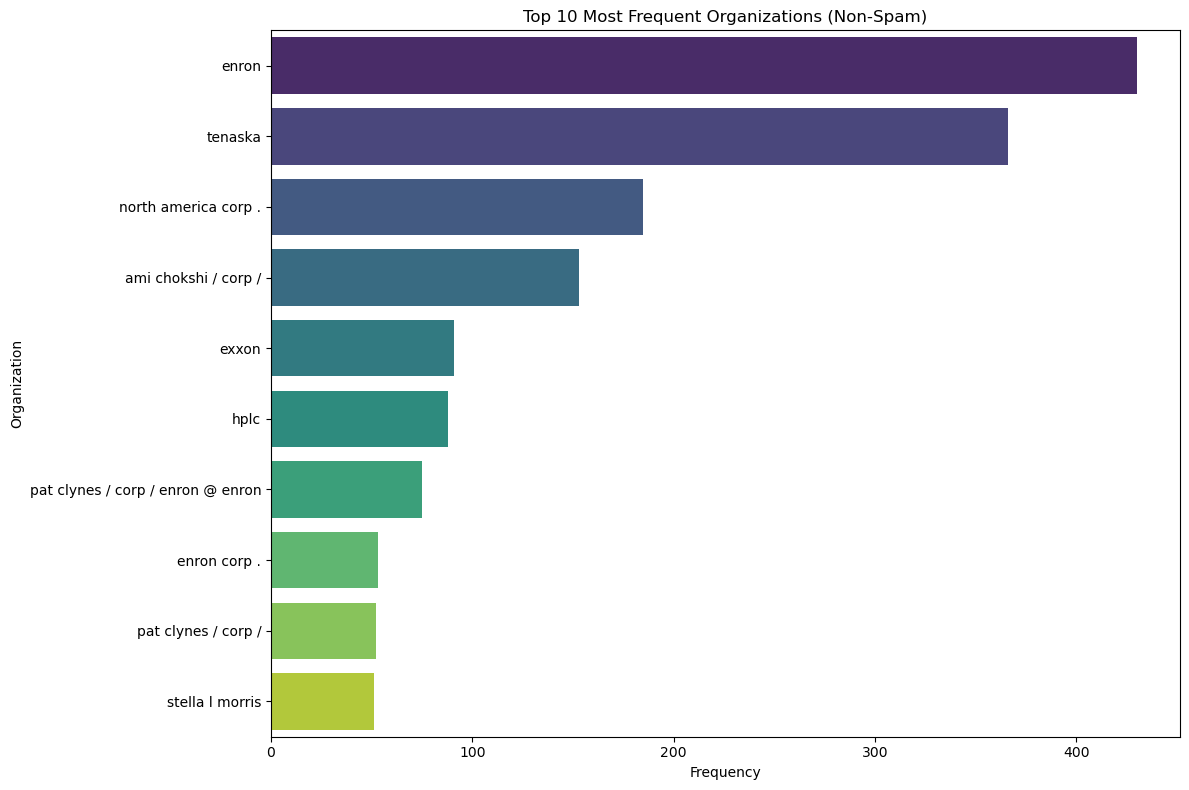

In [32]:
# Assuming `df` is your input DataFrame with "text" and "label" columns
org_df = analyze_non_spam_organizations(df, text_col="text", label_col="label", label_value="ham")

# Plot the top 10 organizations
plot_top_organizations(org_df, top_n=10)

The total number of organizations mentioned is 5,229, with 1,220 unique organizations.
The graph shows the distribution of the 10 most frequently mentioned organizations in non-spam emails.
The Enron organization is mentioned the most, with over 400 mentions, followed by Tenaska, which has more than 350 mentions.
The remaining eight organizations have mentions ranging between 50 and 200.